In [ ]:
!pip install diffusers transformers pyexiv2 huggingface-hub

In [ ]:
from huggingface_hub import login
login(token="huggingface_token")

In [3]:
from diffusers import (
    StableDiffusionXLPipeline,
    DPMSolverMultistepScheduler,
)
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import gc

Load Model

In [ ]:
# CAT - Citron Anime Treasure Illustrious
!curl -L -H "Authorization: Bearer civit_ai_token" \
"https://civitai.com/api/download/models/1881978?type=Model&format=SafeTensor&size=full&fp=fp16" \
-o model.safetensors

In [ ]:
# Animagine XL 3.1
!curl -L -H "Authorization: Bearer civit_ai_token" \
"https://civitai.com/api/download/models/403131?type=Model&format=SafeTensor&size=full&fp=fp16" \
-o model.safetensors

In [ ]:
# Animagine XL 4.0
!curl -L -H "Authorization: Bearer civit_ai_token0" \
"https://civitai.com/api/download/models/1408658?type=Model&format=SafeTensor&size=full&fp=fp16" \
-o model.safetensors

In [ ]:
# Nova Orange XL RE:V1.0
!curl -L -H "Authorization: Bearer civit_ai_token" \
"https://civitai.com/api/download/models/1914444?type=Model&format=SafeTensor&size=pruned&fp=fp16" \
-o model.safetensors

In [ ]:
# MeinaXL V2
!curl -L -H "Authorization: Bearer civit_ai_token" \
"https://civitai.com/api/download/models/995333?type=Model&format=SafeTensor&size=full&fp=fp16" \
-o model.safetensors

In [ ]:
checkpoint_repo = "model.safetensors"

In [ ]:
checkpoint_repo = "nqzfaizal77ai/cassandra-blaze-sdxl-merge-2"

In [4]:
checkpoint_repo = "nqzfaizal77ai/tea-seeker-sdxl-merge-2"

In [5]:
precision = 'half' # @param ["half", "full" ,"bf16"]
if precision == "half":
    selected_precision = torch.float16
elif precision == "full":
    selected_precision = torch.float32
elif precision == "bf16":
    selected_precision = torch.bfloat16

Load From Single File

In [ ]:
pipe = StableDiffusionXLPipeline.from_single_file(checkpoint_repo,
                                            torch_dtype=selected_precision,
                                            use_safetensors=True)

Load Diffuser Huggingface

In [ ]:
pipe = StableDiffusionXLPipeline.from_pretrained(checkpoint_repo,
                                            torch_dtype=selected_precision,
                                            use_safetensors=True)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
pipe.to(device)

In [ ]:
pipe.safety_checker = None
pipe.requires_safety_checker = False
# DPMSolverMultistepScheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config,
    algorithm_type="sde-dpmsolver++",
    use_karras_sigmas=True
)

In [ ]:
prompt = "Jaxon Rivera, a confident and handsome teenage boy with tousled dark brown hair, amber eyes, and a cocky smirk that hints at both charisma and hardship. Slight sweat glistens on his face, and dirt is smudged subtly on his cheekbones. He wears a fitted soccer jersey with the sleeves slightly rolled, showing a lean athletic build. His confident pose has one hand resting near his neck or adjusting his collar. Background is a softly blurred stadium tunnel or sunlit backyard pitch. His expression is cocky but sharp, like someone who’s survived hard times and plays to win. Cinematic portrait, shoulder-up. --v 5 --ar 3:4 --style cinematic --lighting golden_hour --medium digital_painting --quality high --focus face" # @param {type:"string"}
negative_prompt = "bad quality, low quality, zombie, blurry, ugly, disfigured, deformed, bad anatomy, bad hands, bad eyes, watermark, text, signature, extra limbs, fused fingers, out of frame, cropped" # @param {type:"string"}

orientation = 'portrait' # @param ["portrait", "square", "landscape"]

# Set width and height based on orientation, optimized for SDXL
if orientation == 'portrait':
    width = 768
    height = 1024
elif orientation == 'square':
    width = 1024
    height = 1024
elif orientation == 'landscape':
    width = 1024
    height = 768

# width = 960
# height = 704  # Both divisible by 8


size = f"{width}x{height}"

cfg_scale = 8  # @param {type:"integer"}
steps = 28  # @param {type:"integer"}
sampler = "DPM++ SDE Karras"  # @param {type:"string"}
modelname = "tea-seeker-2"  # @param {type:"string"}

Using Prompt Embeddding

In [ ]:
# def get_embeddings(pipe, prompt, negative_prompt):
#     """
#     Gets prompt and negative prompt embeddings for Stable Diffusion XL pipeline.
#     SDXL's encode_prompt returns 4 values:
#     - prompt_embeds
#     - negative_prompt_embeds
#     - pooled_prompt_embeds
#     - negative_pooled_prompt_embeds
#     """
#     return pipe.encode_prompt(
#         prompt=prompt,
#         negative_prompt=negative_prompt,
#     )

# # Usage - now unpacking all 4 return values
# prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds = get_embeddings(pipe, prompt, negative_prompt)

In [ ]:
# # Generate the image using embeddings
# import random

# manual_seed = random.randint(1, 9999999)
# print("seed:", manual_seed)
# generator = torch.Generator(device=device).manual_seed(manual_seed)

# images = pipe(
#     prompt_embeds=prompt_embeds,
#     negative_prompt_embeds=negative_prompt_embeds,
#     pooled_prompt_embeds=pooled_prompt_embeds,
#     negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
#     width=width,
#     height=height,
#     guidance_scale=cfg_scale,
#     num_inference_steps=steps,
#     num_images_per_prompt = 2,
#     generator=generator
# ).images

Using Prompt Embedding 2

In [ ]:
# !pip install torchao --extra-index-url https://download.pytorch.org/whl/cu121 # full options are cpu/cu118/cu121/cu124

In [ ]:
!pip install torchao

In [ ]:
!pip install git+https://github.com/xhinker/sd_embed.git@main

In [21]:
from sd_embed.embedding_funcs import get_weighted_text_embeddings_sdxl

In [30]:
(
    prompt_embeds
    , prompt_neg_embeds
    , pooled_prompt_embeds
    , negative_pooled_prompt_embeds
) = get_weighted_text_embeddings_sdxl(
    pipe
    , prompt = prompt
    , neg_prompt = negative_prompt
)

In [34]:
import random

manual_seed = random.randint(1, 9999999)
print("seed:", manual_seed)
generator = torch.Generator(device=device).manual_seed(manual_seed)

images = pipe(
    prompt_embeds                   = prompt_embeds
    , negative_prompt_embeds        = prompt_neg_embeds
    , pooled_prompt_embeds          = pooled_prompt_embeds
    , negative_pooled_prompt_embeds = negative_pooled_prompt_embeds,
    width=width,
    height=height,
    guidance_scale=cfg_scale,
    num_inference_steps=steps,
    num_images_per_prompt = 2,
    generator                     = generator
).images

seed: 5562107


  0%|          | 0/28 [00:00<?, ?it/s]

No Prompt Embedding

In [ ]:
# Random
import random

manual_seed = random.randint(1,9999999)
print("seed :",manual_seed)
generator = torch.Generator(device=device).manual_seed(manual_seed)
images = pipe(
            prompt = prompt,
            negative_prompt = negative_prompt,
            width = width,
            height = height,
            guidance_scale = cfg_scale,
            num_inference_steps = steps,
            num_images_per_prompt = 2,
            generator = generator
        ).images

In [ ]:
# # Fixed
# manual_seed = 3245
# print("seed :",manual_seed)
# generator = torch.Generator(device=device).manual_seed(manual_seed)
# images = pipe(
#             prompt = prompt,
#             negative_prompt = negative_prompt,
#             width = width,
#             height = height,
#             guidance_scale = cfg_scale,
#             num_inference_steps = steps,
#             num_images_per_prompt = 2,
#             generator = generator
#         ).images

Show Image

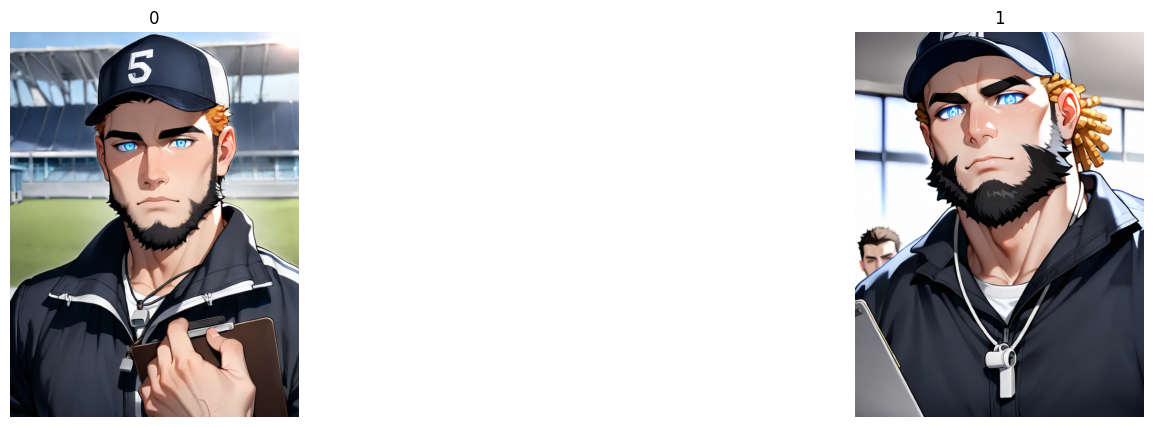

In [35]:
def plot_images(images):
    N = len(images)
    n_cols = 2
    n_rows = int(np.ceil(N / n_cols))

    plt.figure(figsize = (20, 5 * n_rows))
    for i in range(len(images)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.title(i)
        plt.imshow(np.array(images[i]))
        plt.axis(False)
    plt.show()
plot_images(images)

In [33]:
import pyexiv2
import json
import os

def get_unique_filename(base_name, ext):
    """Generate a unique filename by appending a numeric suffix if necessary."""
    counter = 1
    unique_name = f"{base_name}{ext}"
    while os.path.exists(unique_name):
        unique_name = f"{base_name}_{counter}{ext}"
        counter += 1
    return unique_name

for i in range(len(images)):
    # Save image with unique filename
    base_filename = f"image{i}"
    ext = ".png"
    unique_filename = get_unique_filename(base_filename, ext)
    images[i].save(unique_filename)

    metadata_diffusers = {
        "prompt": prompt,
        "negativePrompt": negative_prompt,
        "steps": steps,
        "samplerName": sampler,
        "cfgScale": cfg_scale,
        "seed": manual_seed,
        "clipskip": 1,
        "baseModel": "SDXL",
        "checkpointModel": modelname,
        "seed": manual_seed
    }

    new_metadata = {
        "Exif.Photo.UserComment": metadata_diffusers
    }

    img = pyexiv2.Image(unique_filename)
    img.modify_exif(new_metadata)

# Save metadata to a text file with a unique name
metadata_filename_base = "metadata"
metadata_filename_ext = ".txt"
unique_metadata_filename = get_unique_filename(metadata_filename_base, metadata_filename_ext)
with open(unique_metadata_filename, 'w') as f:
    f.write(json.dumps(metadata_diffusers, indent=4))

Delete All File in Current Folder

In [ ]:
# # prompt: Delete All File in Current Folder

# !rm -rf *

Download Using Ngrok

In [ ]:
!pip install pyngrok

In [ ]:
import os
import zipfile
from pyngrok import ngrok
from IPython.display import HTML, display

# Set your Ngrok auth token here (replace with your actual token)
NGROK_AUTH_TOKEN = "ngrok_token"  # Example: "2FzA5b3...W9s4Q"

# Authenticate ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Create zip file
zip_filename = "images_and_metadata.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir():
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp', '.txt')):
            zipf.write(file)

# Get absolute path to the file
file_path = os.path.abspath(zip_filename)

# Create a simple HTTP server to serve the file (required for ngrok)
from http.server import SimpleHTTPRequestHandler
from socketserver import TCPServer
import threading

PORT = 8000
Handler = SimpleHTTPRequestHandler

def start_server():
    with TCPServer(("", PORT), Handler) as httpd:
        httpd.serve_forever()

# Start the server in a separate thread
server_thread = threading.Thread(target=start_server)
server_thread.daemon = True
server_thread.start()

# Create ngrok tunnel
public_url = ngrok.connect(PORT, "http").public_url

# Create download link
download_url = f"{public_url}/{zip_filename}"
display(HTML(f'<a href="{download_url}" target="_blank">Download {zip_filename}</a>'))
print(f"Download link: {download_url}")
print("Note: This tunnel will close when the Colab session ends")

In [ ]:
import os
import zipfile

def zip_txt_and_png(directory, zip_name):
    try:
        # Create a ZipFile object
        with zipfile.ZipFile(zip_name, 'w') as zipf:
            # Walk through the directory
            for root, dirs, files in os.walk(directory):
                for file in files:
                    # Check if the file is a .txt or .png
                    if file.endswith('.txt') or file.endswith('.png'):
                        # Create the full filepath by joining the root and file name
                        file_path = os.path.join(root, file)
                        # Add the file to the zip file
                        zipf.write(file_path, os.path.relpath(file_path, directory))

        print(f'Successfully created {zip_name}')

    except FileNotFoundError:
        print(f'Error: File or directory not found.')

    except PermissionError:
        print(f'Error: Permission denied while accessing files.')

    except Exception as e:
        print(f'An unexpected error occurred: {e}')

# Usage example
directory_to_zip = os.getcwd()
output_zip_file = 'research_test_image.zip'
zip_txt_and_png(directory_to_zip, output_zip_file)